In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
import seaborn as sns
import ydf

from statsmodels.stats.outliers_influence import variance_inflation_factor

Data Structure:
cycle:	top level structure array containing the charge, discharge and impedance operations
	type: 	operation  type, can be charge, discharge or impedance
	ambient_temperature:	ambient temperature (degree C)
	time: 	the date and time of the start of the cycle, in MATLAB  date vector format
	data:	data structure containing the measurements
	
	   for charge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at charger (Amps)
		Voltage_charge:		Voltage measured at charger (Volts)
		Time:			Time vector for the cycle (secs)
		
	   for discharge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at load (Amps)
		Voltage_charge:		Voltage measured at load (Volts)
		Time:			Time vector for the cycle (secs)
		Capacity:		Battery capacity (Ahr) for discharge till 2.7V 

	   for impedance the fields are:
		Sense_current:		Current in sense branch (Amps)
		Battery_current:	Current in battery branch (Amps)
		Current_ratio:		Ratio of the above currents 
		Battery_impedance:	Battery impedance (Ohms) computed from raw data
		Rectified_impedance:	Calibrated and smoothed battery impedance (Ohms) 
		Re:			Estimated electrolyte resistance (Ohms)
		Rct:			Estimated charge transfer resistance (Ohms)


## .mat to DF

In [38]:
mat = scipy.io.loadmat("C:/Users/cakir/python_scripts/yed_interview/artifacts/data/B0006.mat", squeeze_me=True, struct_as_record=False)
block1 = mat["B0006"]

records = []

for c in block1.cycle:
    base = {
        "type": c.type,
        "ambient_temperature": c.ambient_temperature,
        "time": c.time
    }

    if c.type == "discharge":
        base.update({
            "Voltage_measured": c.data.Voltage_measured,
            "Current_measured": c.data.Current_measured,
            "Temperature_measured": c.data.Temperature_measured,
            "Current_charge": c.data.Current_load,
            "Voltage_charge": c.data.Voltage_load,
            "Time": c.data.Time,
            "Capacity": c.data.Capacity
        })
    else:
        continue
        
    records.append(base)
    
df = pd.DataFrame(records)



In [39]:
df.head()

,type,ambient_temperature,time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,Capacity
0,discharge,24,"[2008.0, 4.0, 2.0, 15.0, 25.0, 41.593]","[4.179799607333447, 4.179823027658306, 3.96652...","[-0.0023663271409738672, 0.0004337624657511786...","[24.277567510331888, 24.27707330832413, 24.366...","[-0.0006, -0.0006, -1.999, -1.999, -1.999, -1....","[0.0, 4.195, 3.07, 3.045, 3.026, 3.011, 3.002,...","[0.0, 16.781, 35.702999999999996, 53.781, 71.9...",2.035338
1,discharge,24,"[2008.0, 4.0, 2.0, 19.0, 43.0, 48.406]","[4.177288238505559, 4.17694566937783, 3.969923...","[-0.0033319109110022693, -0.000207646083278796...","[24.648610618159957, 24.63823886086074, 24.706...","[-0.0006, -0.0006, -1.999, -1.999, -1.999, -1....","[0.0, 4.192, 3.076, 3.052, 3.032, 3.018, 3.009...","[0.0, 16.672, 35.703, 53.828, 71.891, 90.047, ...",2.025140
2,discharge,24,"[2008.0, 4.0, 3.0, 0.0, 1.0, 6.687]","[4.177795470598289, 4.1781213228922995, 3.9727...","[-0.0013875878795131932, -0.000657549215012753...","[24.704057719023776, 24.705141356588655, 24.76...","[-0.0006, -0.0006, -1.999, -1.999, -1.999, -1....","[0.0, 4.193, 3.079, 3.055, 3.034, 3.022, 3.013...","[0.0, 16.796999999999997, 35.766, 53.891, 72.0...",2.013326
3,discharge,24,"[2008.0, 4.0, 3.0, 4.0, 16.0, 37.375]","[4.178370492084649, 4.1785623580417175, 3.9741...","[-0.002003525775696755, 0.0001981188152475248,...","[24.650503100456078, 24.648384924528084, 24.71...","[-0.0006, -0.0006, -1.999, -1.999, -1.999, -1....","[0.0, 4.194, 3.081, 3.057, 3.035, 3.023, 3.014...","[0.0, 16.766000000000002, 35.75, 53.813, 72.04...",2.013285
4,discharge,24,"[2008.0, 4.0, 3.0, 8.0, 33.0, 25.703]","[4.178015652407259, 4.17824995156942, 3.974047...","[-0.0011423311186216645, -0.004132794108565521...","[24.634206199911688, 24.635355742907162, 24.69...","[-0.0006, -0.0006, -1.999, -1.999, -1.999, -1....","[0.0, 4.193, 3.08, 3.056, 3.035, 3.022, 3.012,...","[0.0, 16.719, 35.656000000000006, 53.859, 72.0...",2.000528


## Time Lists to Timestamp

In [40]:
def mat2df(row):
    return datetime(
        int(row.time[0]), int(row.time[1]), int(row.time[2]), int(row.time[3]), int(row.time[4]), int(row.time[5])
    )
    
df["time"] = df.apply(mat2df, axis=1)

## Calculate SoC

In [41]:
def calc_soc(time_discharge, current_discharge, capacity):
    if type(time_discharge) is float:
        return np.nan
    dt = np.diff(time_discharge, prepend=0)  # saniye cinsinden zaman farkı
    charge_consumed = np.cumsum(np.abs(current_discharge) * dt) / (3600)  # Ah cinsinden
    soc = 1 - charge_consumed / capacity # SoC = 1 - (tüketilen şarj / nominal kapasite)
    return soc

df["soc"] = df.apply(lambda x: calc_soc(x["Time"], x["Current_charge"], x["Capacity"]), axis=1)

## Equalize Each Row with Same Length

In [42]:
def equalize(voltages, target_len):
    if type(voltages) is float:
        return np.full(target_len, np.nan)
    if len(voltages) < 2:
        return np.full(target_len, np.nan)
    if len(voltages) == target_len:
        return voltages
    return np.interp(np.linspace(0, 1, target_len), np.linspace(0, 1, len(voltages)), voltages)

target_len = df["Time"].apply(lambda x: len(x)).max() #get max Time length

df["Voltage_measured"] = df.apply(lambda x: equalize(x["Voltage_measured"], target_len), axis=1)
df["Current_charge"] = df.apply(lambda x: equalize(x["Current_charge"], target_len), axis=1)
df["Temperature_measured"] = df.apply(lambda x: equalize(x["Temperature_measured"], target_len), axis=1)
df["Voltage_charge"] = df.apply(lambda x: equalize(x["Voltage_charge"], target_len), axis=1)
df["Current_measured"] = df.apply(lambda x: equalize(x["Current_measured"], target_len), axis=1)
df["Time"] = df.apply(lambda x: equalize(x["Time"], target_len), axis=1)
df["soc"] = df.apply(lambda x: equalize(x["soc"], target_len), axis=1)

In [43]:
df.head(1)

,type,ambient_temperature,time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,Capacity,soc
0,discharge,24,2008-04-02 15:25:41,"[4.179799607333447, 4.179812013775805, 4.16714...","[-0.0023663271409738672, -0.000883036430384383...","[24.277567510331888, 24.277305716835887, 24.28...","[-0.0006, -0.0006, -0.11942378378378408, -1.17...","[0.0, 2.222216216216217, 4.128108108108108, 3....","[0.0, 8.889394594594595, 17.906091891891894, 2...",2.035338,"[1.0, 0.9999992720786113, 0.9996916799642319, ..."


## Explode Rows

In [44]:
cols_to_explode = df.drop(["type", "time", "ambient_temperature", "Capacity"], axis=1).columns.tolist()
df = df.explode(cols_to_explode)

## Inspect the DF

In [45]:
df.info() #object columns should be converted to float

<class 'pandas.core.frame.DataFrame'>
Index: 62328 entries, 0 to 167
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   type                  62328 non-null  object        
 1   ambient_temperature   62328 non-null  int64         
 2   time                  62328 non-null  datetime64[ns]
 3   Voltage_measured      62328 non-null  object        
 4   Current_measured      62328 non-null  object        
 5   Temperature_measured  62328 non-null  object        
 6   Current_charge        62328 non-null  object        
 7   Voltage_charge        62328 non-null  object        
 8   Time                  62328 non-null  object        
 9   Capacity              62328 non-null  float64       
 10  soc                   62328 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 5.7+ MB


In [46]:
df

,type,ambient_temperature,time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,Capacity,soc
0,discharge,24,2008-04-02 15:25:41,4.1798,-0.002366,24.277568,-0.0006,0.0,0.0,2.035338,1.0
0,discharge,24,2008-04-02 15:25:41,4.179812,-0.000883,24.277306,-0.0006,2.222216,8.889395,2.035338,0.999999
0,discharge,24,2008-04-02 15:25:41,4.167141,-0.119358,24.282374,-0.119424,4.128108,17.906092,2.035338,0.999692
0,discharge,24,2008-04-02 15:25:41,4.054152,-1.186592,24.329601,-1.178036,3.532162,27.929638,2.035338,0.996957
0,discharge,24,2008-04-02 15:25:41,3.964074,-2.013587,24.383933,-1.999,3.067027,37.852816,2.035338,0.99425
...,...,...,...,...,...,...,...,...,...,...,...
167,discharge,24,2008-05-27 20:45:42,3.689917,-0.001858,32.442046,0.0006,0.0,2788.795784,1.185675,-0.009557
167,discharge,24,2008-05-27 20:45:42,3.690416,-0.00237,32.391203,0.0006,0.0,2796.684049,1.185675,-0.009558
167,discharge,24,2008-05-27 20:45:42,3.690957,-0.0028,32.304723,0.0006,0.0,2804.593686,1.185675,-0.009559
167,discharge,24,2008-05-27 20:45:42,3.691443,-0.002986,32.241032,0.0006,0.0,2812.510946,1.185675,-0.00956


## Change Columns Data Type to Numeric

In [47]:
cols = df.drop(["type", "time", "ambient_temperature"], axis=1).select_dtypes(include='object').columns

df[cols] = df[cols].apply(pd.to_numeric)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62328 entries, 0 to 167
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   type                  62328 non-null  object        
 1   ambient_temperature   62328 non-null  int64         
 2   time                  62328 non-null  datetime64[ns]
 3   Voltage_measured      62328 non-null  float64       
 4   Current_measured      62328 non-null  float64       
 5   Temperature_measured  62328 non-null  float64       
 6   Current_charge        62328 non-null  float64       
 7   Voltage_charge        62328 non-null  float64       
 8   Time                  62328 non-null  float64       
 9   Capacity              62328 non-null  float64       
 10  soc                   62328 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 5.7+ MB


In [49]:
df.describe()

,ambient_temperature,time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,Capacity,soc
count,62328.0,62328,62328.000000,62328.000000,62328.000000,62328.000000,62328.000000,62328.000000,62328.000000,62328.000000
mean,24.0,2008-05-05 12:23:59.065476096,3.463682,-1.785218,32.794185,1.046130,2.284479,1555.555131,1.546851,0.447969
min,24.0,2008-04-02 15:25:41,2.120698,-2.026243,23.201772,-1.999200,0.000000,0.000000,1.153818,-0.010228
25%,24.0,2008-04-25 08:27:20.750000128,3.328096,-2.011029,29.657760,0.000600,2.342373,769.393824,1.347427,0.159464
50%,24.0,2008-05-07 04:40:43.500000,3.473678,-2.010143,32.872514,1.999000,2.535765,1543.854605,1.485372,0.442740
75%,24.0,2008-05-17 23:24:28,3.627478,-2.009102,35.988512,1.999000,2.702347,2320.316301,1.767208,0.724410
max,24.0,2008-05-27 20:45:42,4.222502,0.008620,42.005209,1.999200,4.205000,3690.234000,2.035338,1.000000
std,0.0,NaN,0.249163,0.630435,4.111186,1.565149,0.830726,913.626529,0.251289,0.316716


# Data Relationships

Text(0.5, 1.0, 'current_measured vs Time')

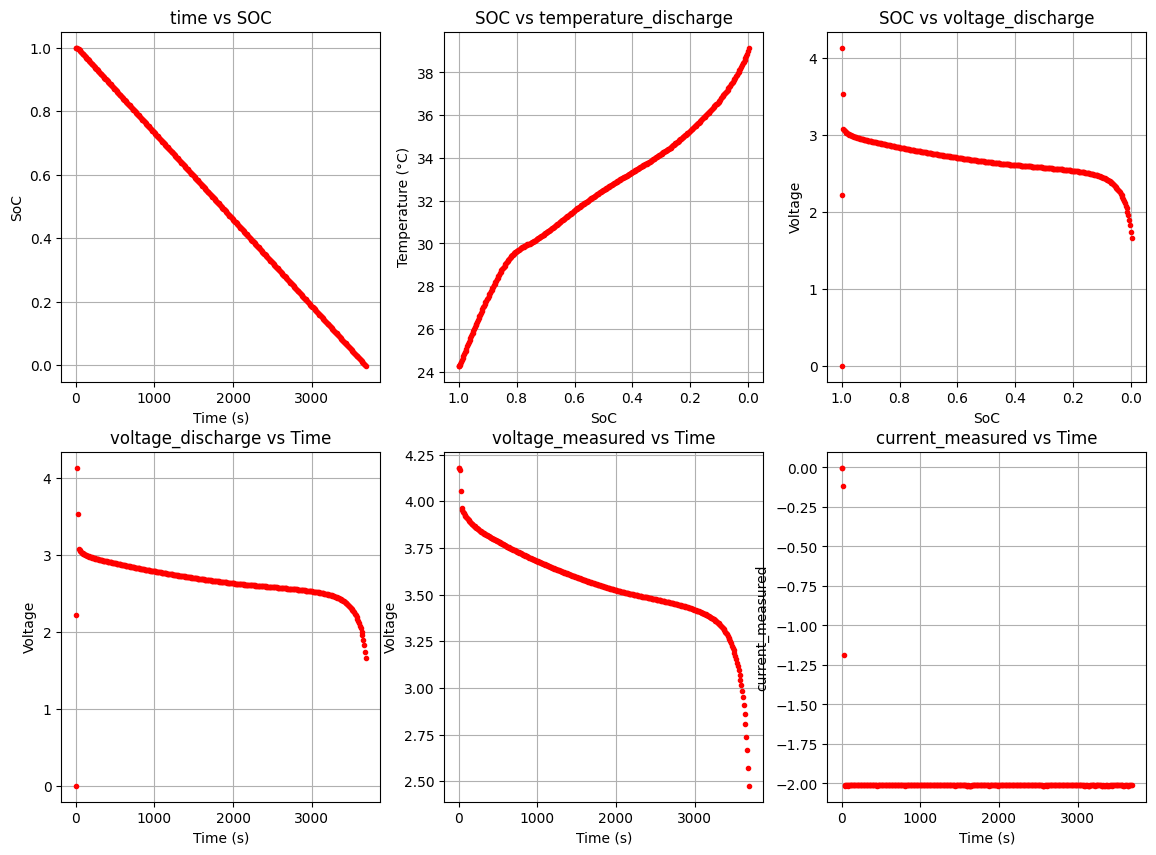

In [50]:
all_soc = []

idx = 0

current_discharge = df.loc[idx, "Current_charge"]
current_measured = df.loc[idx, "Current_measured"].values
voltage_discharge = df.loc[idx, "Voltage_charge"].values
voltage_measured = df.loc[idx, "Voltage_measured"].values
time_discharge = df.loc[idx, "Time"].values
temperature_discharge = df.loc[idx, "Temperature_measured"].values
capacity = df.loc[idx, "Capacity"].values
soc = df.loc[idx, "soc"].values

fig, ax = plt.subplots(2, 3, figsize=(14,10))

ax = ax.ravel()
ax[0].plot(time_discharge, soc,  '.', label="discharge", color="red")
ax[0].grid(True)  
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("SoC")
ax[0].set_title("time vs SOC")

ax[1].plot(soc, temperature_discharge,  '.', label="discharge", color="red")
ax[1].grid(True)  
ax[1].set_xlabel("SoC")
ax[1].set_ylabel("Temperature (°C)")
ax[1].set_title("SOC vs temperature_discharge")
ax[1].invert_xaxis()

ax[2].plot(soc, voltage_discharge,  '.', label="discharge", color="red")
ax[2].grid(True)  
ax[2].set_xlabel("SoC")
ax[2].set_ylabel("Voltage")
ax[2].set_title("SOC vs voltage_discharge")
ax[2].invert_xaxis()

ax[3].plot(time_discharge, voltage_discharge,  '.', label="discharge", color="red")
ax[3].grid(True)  
ax[3].set_xlabel("Time (s)")
ax[3].set_ylabel("Voltage")
ax[3].set_title("voltage_discharge vs Time")

ax[4].plot(time_discharge, voltage_measured,  '.', label="discharge", color="red")
ax[4].grid(True)  
ax[4].set_xlabel("Time (s)")
ax[4].set_ylabel("Voltage")
ax[4].set_title("voltage_measured vs Time")

ax[5].plot(time_discharge, current_measured,  '.', label="discharge", color="red")
ax[5].grid(True)  
ax[5].set_xlabel("Time (s)")
ax[5].set_ylabel("current_measured")
ax[5].set_title("current_measured vs Time")

# Feature Eng

In [51]:
df['Power'] = df['Voltage_measured'] * df['Current_measured']
df['C_rate'] = abs(df['Current_measured']) / df['Capacity']
raw_df = df.copy()

# multicollinarity check

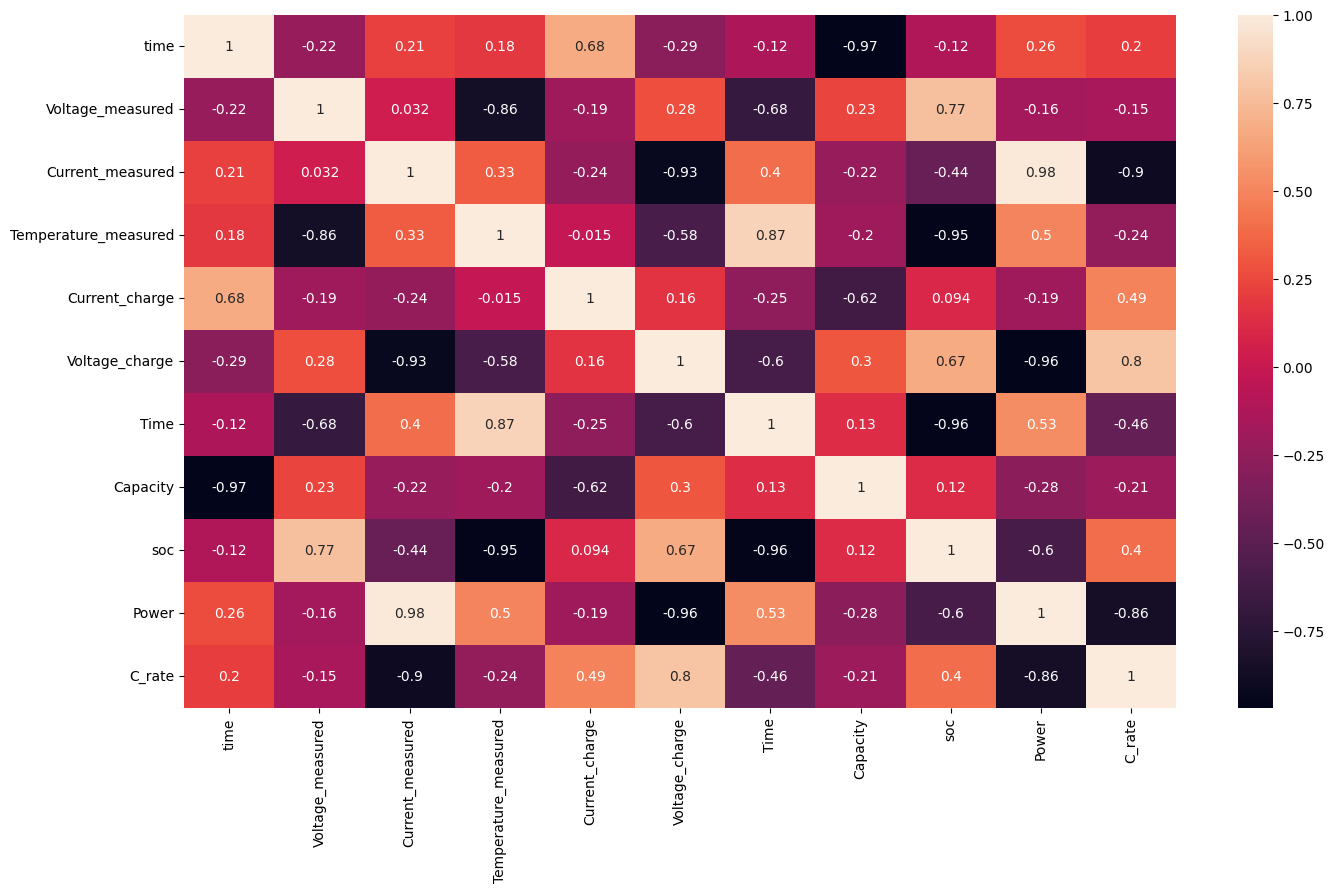

In [52]:
plt.figure(figsize=(16, 9))
sns.heatmap(df.drop(["type", "ambient_temperature"], axis=1).corr(), annot=True)
plt.show()

In [53]:
target_column = df["soc"]

In [54]:
def drop_high_correlations(df: pd.DataFrame) -> pd.DataFrame:
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]
    df.drop(to_drop, axis=1, inplace=True)
    print("Dropped columns:", to_drop)
    return df

df = df.select_dtypes(include=['number']).drop("soc", axis=1)

df = drop_high_correlations(df.select_dtypes(include=['number']))

df = df.fillna(0)

Dropped columns: ['Voltage_charge', 'Power', 'C_rate']


# Calculation of VIF Value

In [55]:
vif_threshold = 10

numeric_cols = df.select_dtypes(include=['number']).columns

X = df[numeric_cols].fillna(df[numeric_cols].mean())

while True:
    vif_df = pd.DataFrame()
    vif_df["feature"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    max_vif = vif_df.loc[vif_df["VIF"].idxmax()]
    if max_vif["VIF"] > vif_threshold:
        print(f"Dropping {max_vif['feature']} with VIF {max_vif['VIF']}")
        X = X.drop(max_vif["feature"], axis="columns")
    else:
        break

print(vif_df)

Dropping ambient_temperature with VIF 4223.99519686787
Dropping Voltage_measured with VIF 219.85702682617978
Dropping Temperature_measured with VIF 63.93940402009023
Dropping Capacity with VIF 20.799821138742292
            feature       VIF
0  Current_measured  3.018811
1    Current_charge  1.556089
2              Time  2.288073


# Same Stages for Test DF

In [56]:
mat = scipy.io.loadmat("C:/Users/cakir/python_scripts/yed_interview/artifacts/data/B0007.mat", squeeze_me=True, struct_as_record=False)
block1 = mat["B0007"]
records = []

for c in block1.cycle:
    base = {
        "type": c.type,
        "ambient_temperature": c.ambient_temperature,
        "time": c.time
    }
    
    if c.type == "discharge":
        base.update({
            "Voltage_measured": c.data.Voltage_measured,
            "Current_measured": c.data.Current_measured,
            "Temperature_measured": c.data.Temperature_measured,
            "Current_charge": c.data.Current_load,
            "Voltage_charge": c.data.Voltage_load,
            "Time": c.data.Time,
            "Capacity": c.data.Capacity
        })
    else:
        continue
        
    records.append(base)

test_df = pd.DataFrame(records)

def mat2df(row):
    return datetime(
        int(row.time[0]), int(row.time[1]), int(row.time[2]), int(row.time[3]), int(row.time[4]), int(row.time[5])
    )
    
test_df["time"] = test_df.apply(mat2df, axis=1)

def calc_soc(time_discharge, current_discharge, capacity):
    if type(time_discharge) is float:
        return np.nan
    dt = np.diff(time_discharge, prepend=0) 
    charge_consumed = np.cumsum(np.abs(current_discharge) * dt) / (3600)  
    soc = 1 - charge_consumed / capacity 
    return soc

test_df["soc"] = test_df.apply(lambda x: calc_soc(x["Time"], x["Current_charge"], x["Capacity"]), axis=1)

def equalize(voltages, target_len):
    if type(voltages) is float:
        return np.full(target_len, np.nan)
    if len(voltages) < 2:
        return np.full(target_len, np.nan)
    if len(voltages) == target_len:
        return voltages
    return np.interp(np.linspace(0, 1, target_len), np.linspace(0, 1, len(voltages)), voltages)

target_len = test_df["Time"].apply(lambda x: len(x)).max()

test_df["Voltage_measured"] = test_df.apply(lambda x: equalize(x["Voltage_measured"], target_len), axis=1)
test_df["Current_charge"] = test_df.apply(lambda x: equalize(x["Current_charge"], target_len), axis=1)
test_df["Temperature_measured"] = test_df.apply(lambda x: equalize(x["Temperature_measured"], target_len), axis=1)
test_df["Voltage_charge"] = test_df.apply(lambda x: equalize(x["Voltage_charge"], target_len), axis=1)
test_df["Current_measured"] = test_df.apply(lambda x: equalize(x["Current_measured"], target_len), axis=1)
test_df["Time"] = test_df.apply(lambda x: equalize(x["Time"], target_len), axis=1)
test_df["soc"] = test_df.apply(lambda x: equalize(x["soc"], target_len), axis=1)

test_df = test_df.apply(pd.Series.explode)

test_df['Power'] = test_df['Voltage_measured'] * test_df['Current_measured']
test_df['C_rate'] = abs(test_df['Current_measured']) / test_df['Capacity']

test_df = test_df.fillna(0)

basic_test_df = test_df[["Current_measured", "Current_charge", "Time", "soc"]]

basic_test_df = basic_test_df.apply(pd.to_numeric)

C:\Users\cakir\AppData\Local\Temp\ipykernel_30664\2476460957.py:70: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df = test_df.fillna(0)


In [57]:
X_test = basic_test_df.drop(["soc"], axis=1)
y_test = basic_test_df["soc"]

# TRAIN

In [58]:
y = target_column

scaler = StandardScaler()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [59]:
lgbm_model = LGBMRegressor()
lgbm_model.fit(X_train, y_train)
lgbm_model_pred = lgbm_model.predict(X_val)
mse = mean_squared_error(y_val, lgbm_model_pred)
print("Validation MSE score:", mse)



test_pred_lgbm = lgbm_model.predict(X_test)
print("Test MSE score:", mean_squared_error(y_test, test_pred_lgbm))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 49862, number of used features: 3
[LightGBM] [Info] Start training from score 0.447503
Validation MSE score: 0.0026693709334043715
Test MSE score: 0.0019743667166655502


c:\Users\cakir\python_scripts\yed_interview\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\cakir\python_scripts\yed_interview\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [60]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_model_pred = xgb_model.predict(X_val)
mse = mean_squared_error(y_val, xgb_model_pred)
print("Validation MSE score:", mse)


test_pred_xgb = xgb_model.predict(X_test)
print("Test MSE score:", mean_squared_error(y_test, test_pred_xgb))

Validation MSE score: 0.002759579165308494
Test MSE score: 0.00651375684261366


In [61]:
rf_model = RandomForestRegressor(n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_model_pred = rf_model.predict(X_val)
mse = mean_squared_error(y_val, rf_model_pred)

print("Validation MSE score:", mse)

test_pred_rf = rf_model.predict(X_test)
print("Test MSE score:", mean_squared_error(y_test, test_pred_rf))

Validation MSE score: 0.003027197693708426
Test MSE score: 0.005017559487007756


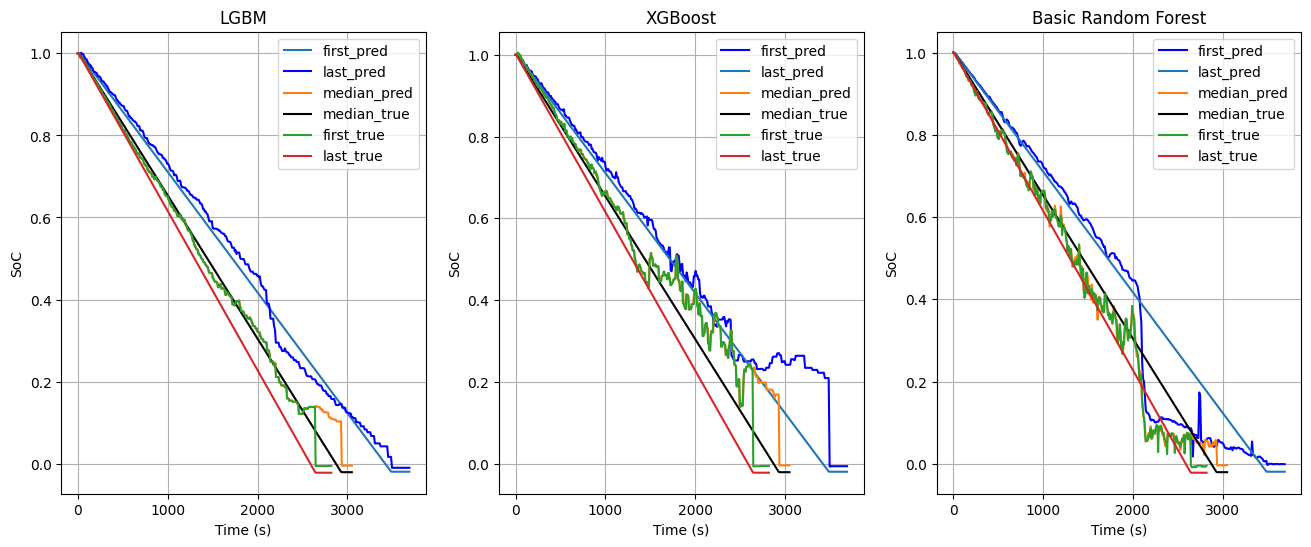

In [62]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

ax[0].plot(test_df["Time"].loc[0], test_df["soc"].loc[0])
ax[0].plot(test_df["Time"].loc[0], test_pred_lgbm[:371], color="blue")
ax[0].plot(test_df["Time"].loc[88], test_pred_lgbm[88*371:88*371+371])
ax[0].plot(test_df["Time"].loc[88], test_df["soc"].loc[88], color="black")
ax[0].plot(test_df["Time"].loc[167], test_pred_lgbm[167*371:167*371+371])
ax[0].plot(test_df["Time"].loc[167], test_df["soc"].loc[167])
ax[0].legend(["first_pred", "last_pred", "median_pred", "median_true", "first_true", "last_true"])
ax[0].set_title("LGBM")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("SoC")
ax[0].grid(True)

ax[1].plot(test_df["Time"].loc[0], test_pred_xgb[:371], color="blue")
ax[1].plot(test_df["Time"].loc[0], test_df["soc"].loc[0])
ax[1].plot(test_df["Time"].loc[88], test_pred_xgb[88*371:88*371+371])
ax[1].plot(test_df["Time"].loc[88], test_df["soc"].loc[88], color="black")
ax[1].plot(test_df["Time"].loc[167], test_pred_xgb[167*371:167*371+371])
ax[1].plot(test_df["Time"].loc[167], test_df["soc"].loc[167])
ax[1].legend(["first_pred", "last_pred", "median_pred", "median_true", "first_true", "last_true"])
ax[1].set_title("XGBoost")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("SoC")
ax[1].grid(True)

ax[2].plot(test_df["Time"].loc[0], test_pred_rf[:371], color="blue")
ax[2].plot(test_df["Time"].loc[0], test_df["soc"].loc[0])
ax[2].plot(test_df["Time"].loc[88], test_pred_rf[88*371:88*371+371])
ax[2].plot(test_df["Time"].loc[88], test_df["soc"].loc[88], color="black")
ax[2].plot(test_df["Time"].loc[167], test_pred_rf[167*371:167*371+371])
ax[2].plot(test_df["Time"].loc[167], test_df["soc"].loc[167])
ax[2].legend(["first_pred", "last_pred", "median_pred", "median_true", "first_true", "last_true"])
ax[2].set_title("Basic Random Forest")
ax[2].set_xlabel("Time (s)")
ax[2].set_ylabel("SoC")
ax[2].grid(True)

In [63]:
train_df = raw_df.drop(["time"], axis=1)

In [64]:
model_gbtrees = ydf.GradientBoostedTreesLearner(label="soc", task=ydf.Task.REGRESSION, num_threads=8).train(train_df)
model_ydf_rf = ydf.RandomForestLearner(label="soc", task=ydf.Task.REGRESSION, num_threads=8).train(train_df)

Train model on 62328 examples
Model trained in 0:00:04.128095
Train model on 62328 examples
Model trained in 0:00:07.719383


# Feature Selection

In [65]:
model_ydf_rf.evaluate(test_df)

Evaluation()

In [66]:
model_ydf_rf.analyze(test_df)

In [67]:
    # 1.                 "Time"  0.153185 ################
    # 2. "Temperature_measured"  0.108027 ###########
    # 3.                "Power"  0.037501 ###
    # 4.     "Voltage_measured"  0.022708 ##
    # 5.       "Voltage_charge"  0.022389 ##

In [69]:
cols = ["Time", "Temperature_measured", "Power", "Voltage_measured", "Voltage_charge", "soc"]
train_df = train_df[cols]
test_df = test_df[cols]

In [70]:
model_gbtrees = ydf.GradientBoostedTreesLearner(label="soc", task=ydf.Task.REGRESSION, num_threads=8).train(train_df)
y_pred_gb = model_gbtrees.predict(test_df)
y_true = test_df["soc"]

mse = mean_squared_error(y_true, y_pred_gb)
print("Gradient Boosted Trees MSE:", mse)
print("Gradient Boosted Trees RMSE:", np.sqrt(mse))

Train model on 62328 examples
Model trained in 0:00:03.686463
Gradient Boosted Trees MSE: 0.00036995308608428815
Gradient Boosted Trees RMSE: 0.019234164553842418


In [71]:
model_ydf_rf = ydf.RandomForestLearner(label="soc", task=ydf.Task.REGRESSION, num_threads=8).train(train_df)
y_pred_rf = model_ydf_rf.predict(test_df)
y_true = test_df["soc"]

mse = mean_squared_error(y_true, y_pred_rf)
print("YDF Random Forest MSE:", mse)
print("YDF Random Forest RMSE:", np.sqrt(mse))

Train model on 62328 examples
Model trained in 0:00:05.427179
YDF Random Forest MSE: 0.00034518200457847673
YDF Random Forest RMSE: 0.018579074373565457


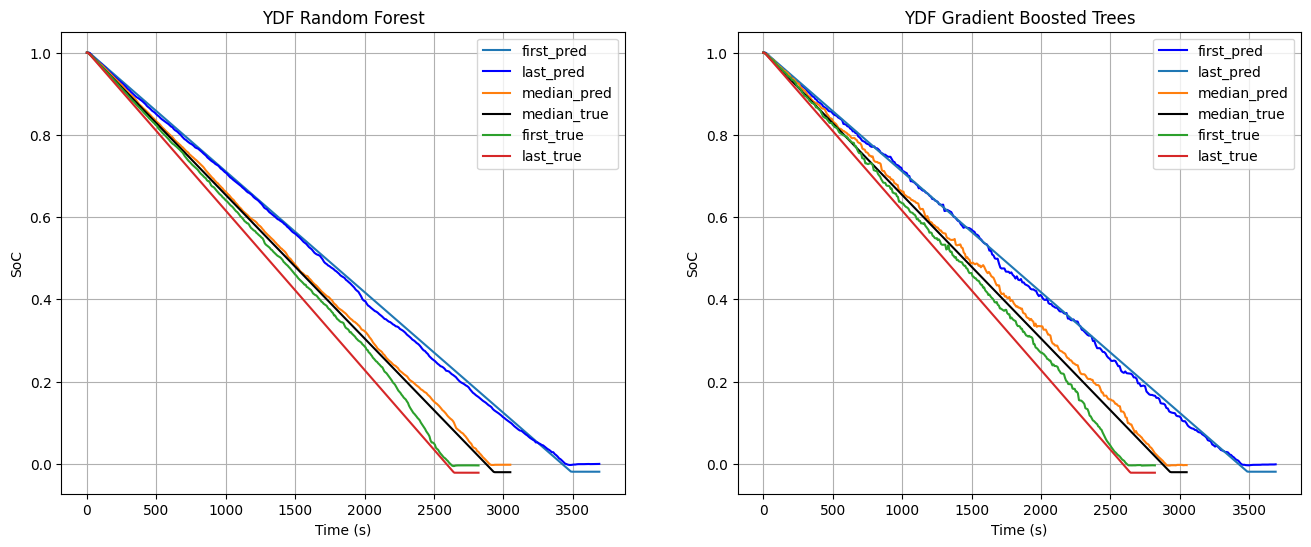

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(test_df["Time"].loc[0], test_df["soc"].loc[0])
ax[0].plot(test_df["Time"].loc[0], y_pred_rf[:371], color="blue")
ax[0].plot(test_df["Time"].loc[88], y_pred_rf[88*371:88*371+371])
ax[0].plot(test_df["Time"].loc[88], test_df["soc"].loc[88], color="black")
ax[0].plot(test_df["Time"].loc[167], y_pred_rf[167*371:167*371+371])
ax[0].plot(test_df["Time"].loc[167], test_df["soc"].loc[167])
ax[0].legend(["first_pred", "last_pred", "median_pred", "median_true", "first_true", "last_true"])
ax[0].set_title("YDF Random Forest")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("SoC")
ax[0].grid(True)

ax[1].plot(test_df["Time"].loc[0], y_pred_gb[:371], color="blue")
ax[1].plot(test_df["Time"].loc[0], test_df["soc"].loc[0])
ax[1].plot(test_df["Time"].loc[88], y_pred_gb[88*371:88*371+371])
ax[1].plot(test_df["Time"].loc[88], test_df["soc"].loc[88], color="black")
ax[1].plot(test_df["Time"].loc[167], y_pred_gb[167*371:167*371+371])
ax[1].plot(test_df["Time"].loc[167], test_df["soc"].loc[167])
ax[1].legend(["first_pred", "last_pred", "median_pred", "median_true", "first_true", "last_true"])
ax[1].set_title("YDF Gradient Boosted Trees")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("SoC")
ax[1].grid(True)

In [464]:
model_ydf_rf.save("artifacts/model_weight/my_model")